In [ ]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast, RandomCrop, Lambda
from keras.preprocessing.image import ImageDataGenerator, smart_resize
from sklearn.metrics import confusion_matrix
import random
import seaborn as sn
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [ ]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)

Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [ ]:
## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip(),
        Lambda(tf.keras.applications.inception_resnet_v2.preprocess_input, input_shape=(224,224,3))
])

base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape = (224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

drop_r = 0.5

prediction_layer = Sequential([BatchNormalization(),
                               Dense(1024,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                               Dropout(drop_r),
                               Dense(256,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                               Dense(29,activation="softmax")])

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([entrada,
                    augmentation,
                    base_model,
                    prediction_layer])


opt = Adam(learning_rate=0.01)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)



Epoch 1/100
257/257 [==============================] - 186s 668ms/step - loss: 3.5343 - accuracy: 0.4436 - val_loss: 2.9118 - val_accuracy: 0.5592
Epoch 2/100
257/257 [==============================] - 168s 653ms/step - loss: 2.7930 - accuracy: 0.5628 - val_loss: 2.4758 - val_accuracy: 0.6098
Epoch 3/100
257/257 [==============================] - 168s 652ms/step - loss: 2.4139 - accuracy: 0.5983 - val_loss: 2.2009 - val_accuracy: 0.6279
Epoch 4/100
257/257 [==============================] - 168s 651ms/step - loss: 2.1838 - accuracy: 0.6100 - val_loss: 1.9887 - val_accuracy: 0.6469
Epoch 5/100
257/257 [==============================] - 168s 651ms/step - loss: 1.9898 - accuracy: 0.6257 - val_loss: 1.8688 - val_accuracy: 0.6410
Epoch 6/100
257/257 [==============================] - 168s 652ms/step - loss: 1.8675 - accuracy: 0.6366 - val_loss: 1.7756 - val_accuracy: 0.6498
Epoch 7/100
257/257 [==============================] - 168s 651ms/step - loss: 1.7720 - accuracy: 0.6437 - val_loss: 1

In [ ]:
model.save('/content/drive/MyDrive/Colab/m.h5')

In [ ]:

for i, layer in enumerate(base_model.layers):
  print(i,layer.name)

In [ ]:

def unfreeze_model(m):
  for layer in m.layers[750]:
    layer.trainable = True

  return m

  

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab/m.h5')

model = unfreeze_model(model)

opt = Adam(learning_rate=1e-3)
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
              metrics=['accuracy'])


callback = EarlyStopping(patience=5,restore_best_weights=True)
history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

model.save('/content/drive/MyDrive/Colab/model_tunned.h5')

In [ ]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [ ]:
## Creamos el csv con los resultados
!rm Sentinel2LULC_Test/.nomedia
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('resultados.csv', index=False)
files.download('resultados.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

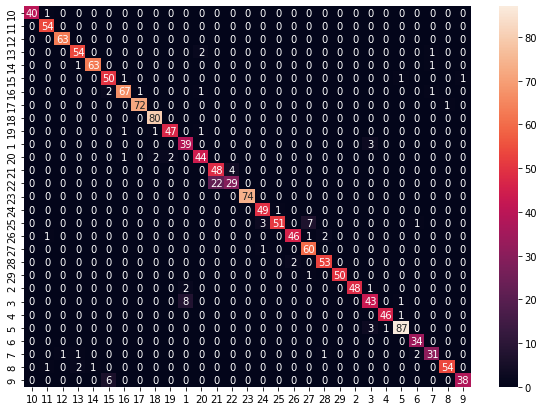

In [ ]:
## Sacamos la matriz de confusion

clases = []
dirname = sorted(os.listdir("Sentinel2LULC_Test"))
for names in dirname:
  clases.append(names.split('_')[0])

clases = [int(x) for x in clases]

indexes = [i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)]

matrix = confusion_matrix(clases, list(classes),labels=indexes)

df_cm = pd.DataFrame(matrix, index = indexes, columns = indexes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)